In [1]:
import os
from datetime import datetime
import traceback
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as tf
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
from PIL import Image, ImageOps

from tqdm import tqdm
from tensorboardX import SummaryWriter

from dataset import score
from resnet import resnet
from resnet import transforms as aug


In [2]:
# consts

tag = 'debug'
root_path = '/home/voyager/data/root/'
split_name = 'score-1'

train_file = os.path.join(root_path, '{}_train.csv'.format(split_name))

batch_size = 32
num_workers = 8
depth = 50
device_name = 'cuda:1'

epochs = 500
lr = 1e-4
patience = 3

image_size = 224
num_classes = 1

mean = 78.416294
std = 7.549563

# info and deps
now = datetime.now()

if not os.path.exists('./result'):
    os.mkdir('./result')

result_path = './result/{}_{}_{}_{}'.format(
    tag,
    depth,
    split_name,
    now.strftime('%Y%m%d_%H%M%S')
)

summary_writer = SummaryWriter(result_path)


# statistics

first we need to do some statistics work

k2: 35.05414863700917, p: 2.4439276199061306e-08
1121


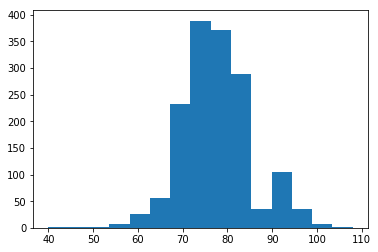

In [3]:
# statistics

train_df = pd.read_csv(train_file)
train_df.describe()

score_list = list(train_df['score'])
k2, p = scipy.stats.normaltest(score_list)

print('k2: {}, p: {}'.format(k2, p))

plt.hist(score_list, 15)

# pick samples with only one root
uids = list(train_df['id'])
uid_counts = {}
for uid in uids:
    if uid in uid_counts.keys():
        uid_counts[uid] += 1
    else:
        uid_counts[uid] = 1

unique_ids = []
unique_count = 0
for uid in uid_counts.keys():
    if uid_counts[uid] == 1:
        unique_count += 1
        unique_ids.append(uid)
        
print(unique_count)


remove extreme points, compute weights for each area

            serial   class        score           x1           y1  \
count  1117.000000  1117.0  1117.000000  1117.000000  1117.000000   
mean      0.294539     0.0    78.416294   227.022381   189.849597   
std       0.569613     0.0     7.549563   161.564269   126.811168   
min       0.000000     0.0    55.000000     1.000000     1.000000   
25%       0.000000     0.0    75.000000   121.000000   104.000000   
50%       0.000000     0.0    79.000000   196.000000   172.000000   
75%       0.000000     0.0    83.000000   291.000000   242.000000   
max       4.000000     0.0   100.000000  1783.000000   924.000000   

                x2           y2    prob  
count  1117.000000  1117.000000  1117.0  
mean    432.827216   470.252462     1.0  
std     233.041357   229.072469     0.0  
min      77.000000    89.000000     1.0  
25%     285.000000   332.000000     1.0  
50%     375.000000   406.000000     1.0  
75%     481.000000   498.000000     1.0  
max    1896.000000  1496.000000     1.0  


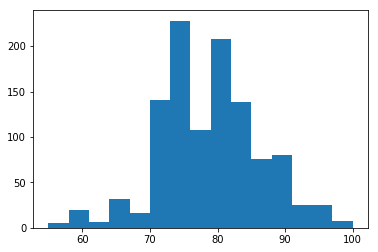

In [4]:
train_df = train_df[train_df['score']>53.6]
train_df = train_df[train_df['score']<103.46666667]
train_df = train_df[train_df['id'].isin(unique_ids)]
print(train_df.describe())

score_list = list(train_df['score'])

counts, bins, patches = plt.hist(score_list, 15)
print(len(counts), len(bins))
print(bins, np.min(score_list), np.max(score_list))


In [5]:
sample_count = 1117
bin_count = len(counts)

# each weight, amplifies a single class to total count
# so we have class_num * total input by applying weights
weights = [sample_count / count for count in counts]

# normalize weights so we don't have to adjust learning rate
# weight / weight_sum * (weight_sum / bin_count)
weights = [weight / bin_count for weight in weights]

print(weights)


[14.893333333333334, 3.7233333333333336, 12.41111111111111, 2.3270833333333334, 4.654166666666667, 0.5281323877068558, 0.3266081871345029, 0.6895061728395062, 0.3580128205128205, 0.5357314148681056, 0.9798245614035088, 0.9308333333333334, 2.978666666666667, 2.978666666666667, 9.308333333333334]


In [6]:
weight_list = []

for score_value in score_list:
    # find out score weight
    for i in range(len(counts)):
        if i == len(counts) - 1:
            weight_list.append(weights[i])
        elif bins[i] <= score_value and bins[i+1] > score_value:
            weight_list.append(weights[i])
            break
            
train_df.insert(len(train_df.columns), 'weight', weight_list)
train_df.head(5)

train_df.to_csv(os.path.join(root_path, '{}_weight_train.csv'.format(split_name)), index=False)

# dataloader

In [4]:
# transforms for train
trans = transforms.Compose([
    aug.AutoLevel(),
    aug.AutoContrast(),
    aug.Contrast(contrast=1.2),
    transforms.ColorJitter(contrast=0.1),
    aug.Pad(), # pad to square
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(15, translate=(0.1, 0.1), scale=(0.8, 1), resample=Image.BILINEAR),
    transforms.Resize(image_size),
    transforms.RandomChoice([
        aug.RandomSaltPepperNoise(0.99, 0.3),
        aug.RandomSaltPepperNoise(0.97, 0.3)
    ]),
    transforms.ToTensor()
])

target_trans = score.ScoreNormalize(mean, std)

train_set = score.ScoreDataset(
    root_path,
    crop_set='manual_crop',
    transforms=trans,
    target_transforms=target_trans,
    weight=True
)

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=score.collate,
    num_workers=num_workers
)


score: 2.5940184593200684, weight: 9.308333396911621


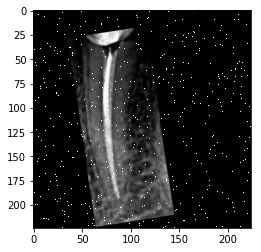

score: -1.1148054599761963, weight: 0.5281323790550232


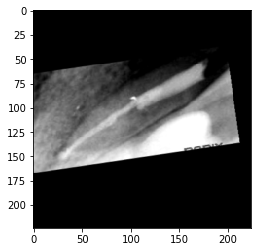

score: -0.9823474287986755, weight: 0.5281323790550232


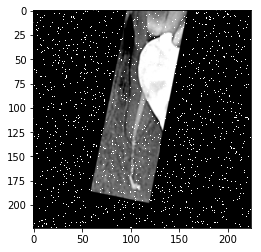

score: -0.45251545310020447, weight: 0.32660818099975586


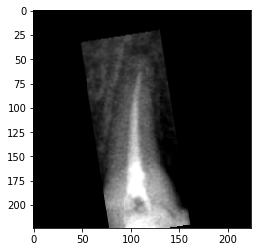

score: 0.20977452397346497, weight: 0.3580128252506256


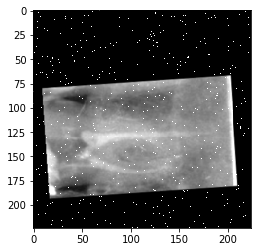

score: -0.45251545310020447, weight: 0.32660818099975586


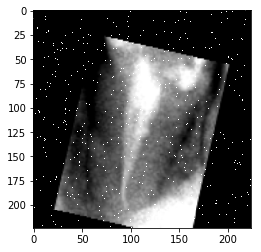

score: 0.20977452397346497, weight: 0.3580128252506256


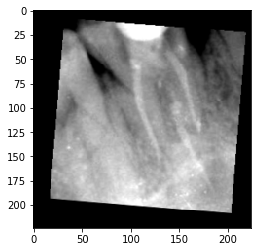

score: 0.8720645308494568, weight: 0.9798245429992676


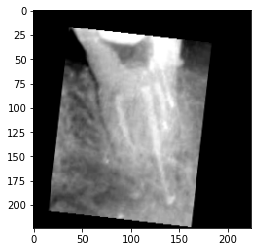

score: -1.7770954370498657, weight: 2.3270833492279053


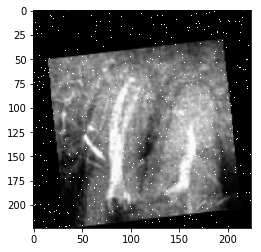

score: 0.8720645308494568, weight: 0.9798245429992676


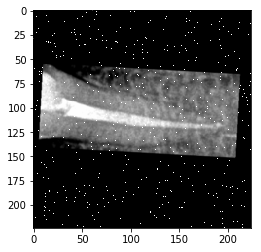

score: 0.20977452397346497, weight: 0.3580128252506256


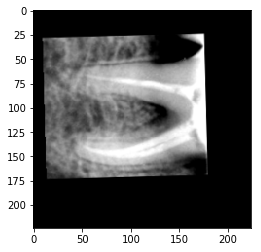

score: 0.20977452397346497, weight: 0.3580128252506256


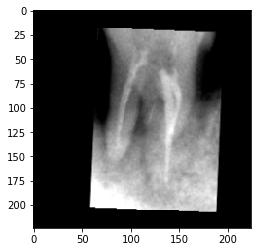

score: -0.055141471326351166, weight: 0.6895061731338501


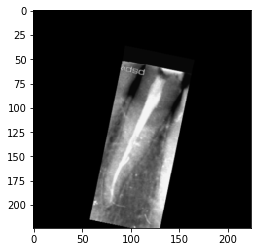

score: -0.45251545310020447, weight: 0.32660818099975586


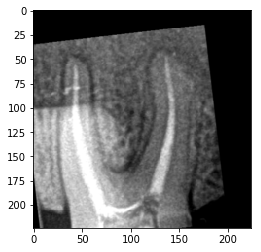

score: 0.739606499671936, weight: 0.5357314348220825


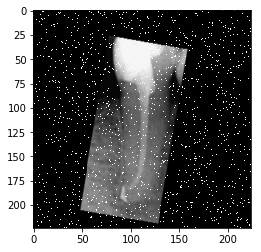

score: 0.6071485280990601, weight: 0.5357314348220825


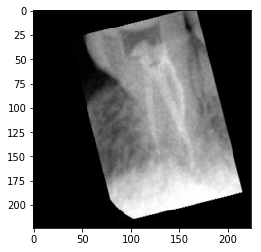

score: 1.5343544483184814, weight: 0.9308333396911621


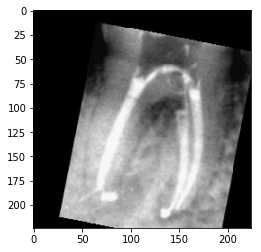

score: 0.20977452397346497, weight: 0.3580128252506256


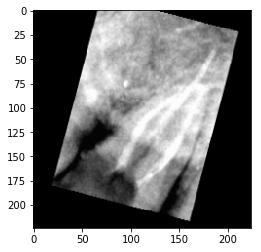

score: 1.931728482246399, weight: 2.9786667823791504


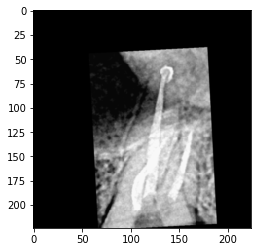

score: -1.5121794939041138, weight: 4.6541666984558105


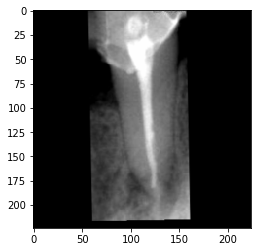

score: -0.5849734544754028, weight: 0.32660818099975586


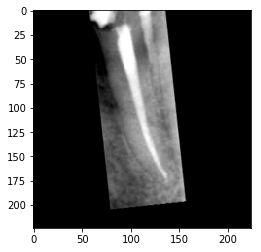

score: 0.20977452397346497, weight: 0.3580128252506256


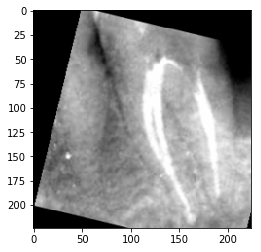

score: 2.0641865730285645, weight: 2.9786667823791504


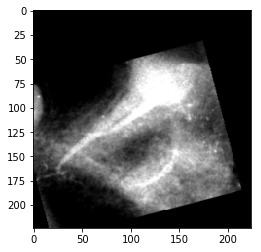

score: 0.20977452397346497, weight: 0.3580128252506256


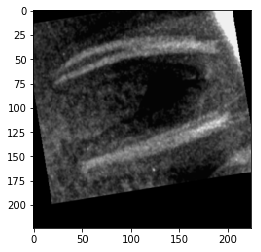

score: 2.5940184593200684, weight: 9.308333396911621


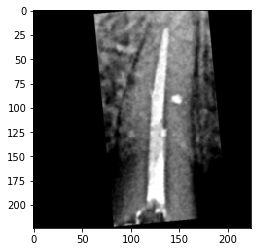

score: -0.18759946525096893, weight: 0.6895061731338501


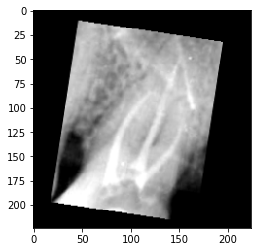

score: 0.20977452397346497, weight: 0.3580128252506256


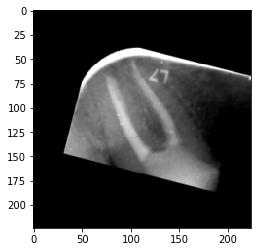

score: 0.20977452397346497, weight: 0.3580128252506256


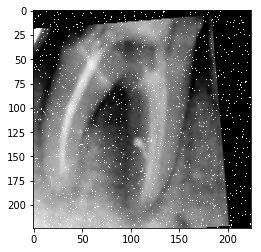

score: -0.45251545310020447, weight: 0.32660818099975586


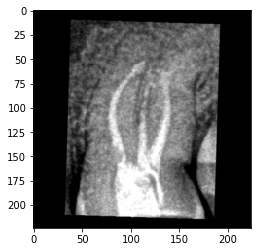

score: -0.45251545310020447, weight: 0.32660818099975586


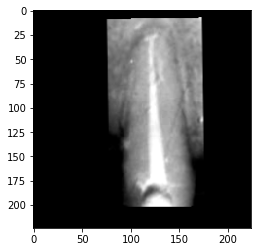

score: 0.6071485280990601, weight: 0.5357314348220825


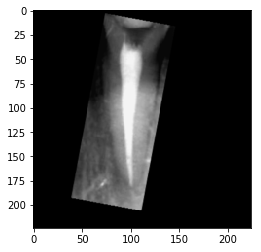

score: -0.45251545310020447, weight: 0.32660818099975586


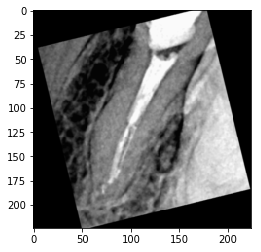

In [6]:
# now let's show a batch of samples, omit this step if you're actually training:
for batch in train_loader:
        imgs, annos = batch
        scores, weights = annos
        
        for img, s, w in zip(imgs, scores, weights):
            print('score: {}, weight: {}'.format(s, w))
            
            plt.imshow(img.numpy().transpose(1, 2, 0))
            plt.show()
            
        break
        

In [7]:
device = torch.device(device_name)

if depth == 34:
    net = resnet.resnet34(num_classes=num_classes, pretrained=True)
elif depth == 50:
    net = resnet.resnet50(num_classes=num_classes, pretrained=True)
elif depth == 101:
    net = resnet.resnet101(num_classes=num_classes, pretrained=True)
elif depth == 152:
    net = resnet.resnet152(num_classes=num_classes, pretrained=True)
    
net = net.to(device)
net.training = True

# TODO : parameters
optimizer = optim.Adam(net.parameters(), lr=lr)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=patience,
    verbose=True
)

# loss
def _pointwise_loss(lambd, lambd_optimized, input, target, weight, reduction='elementwise_mean'):
    d = lambd(input, target, weight)
    if reduction == 'none':
        return d
    return torch.mean(d) if reduction == 'elementwise_mean' else torch.sum(d)
    
def l1_loss(input, target, weight, reduction='elementwise_mean'):
    return _pointwise_loss(lambda a, b, w: torch.abs(a - b) * w, torch._C._nn.l1_loss,
                           input, target, weight, reduction)
    
class WeightedL1Loss(nn.Module):
    def __init__(self):
        super(WeightedL1Loss, self).__init__()
        
    def __call__(self, results, targets, weights):
        return l1_loss(results, targets, weights)

# criterion = nn.L1Loss()
criterion = WeightedL1Loss()

net.train()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [ ]:
# train loop

for epoch in range(epochs):
    print('training epoch {}:'.format(epoch))
    
    # train
    net.train()
    
    epoch_loss = []
    
    with tqdm(total=len(train_loader)) as pbar:
        for i, data in enumerate(train_loader):
            try:
                optimizer.zero_grad()
                
                imgs, annos = data
                scores, weights = annos
                
                # forward
                results = net(imgs.to(device))

                # get loss
                loss = criterion(results.squeeze(), scores.to(device), weights.to(device))
                
                epoch_loss.append(loss.item())
                
                # backward
                loss.backward()
                torch.nn.utils.clip_grad_norm_(net.parameters(), 0.1)
                optimizer.step()
                
                pbar.update(1)
            except Exception as e:
                traceback.print_exc()
                break
                
        # epoch-wise work and record
        mean_loss = np.mean(epoch_loss)
        print('epoch avg loss: {}'.format(mean_loss))
        
        # TODO : it seems we need to do this before epoch 0
        scheduler.step(mean_loss)
        
        # save checkpoint
        torch.save(net, os.path.join(result_path, '{:0>3}_{:1.4f}.pth'.format(
            epoch,
            mean_loss
        )))
        
        # write summary for tensorboardX
        summary_writer.add_scalar(
            '/train/loss',
            mean_loss,
            epoch
        )
        

  0%|          | 0/35 [00:00<?, ?it/s]

training epoch 0:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.3926131572042193
training epoch 1:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.3753375428063528
training epoch 2:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.3570241059575763
training epoch 3:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.2906256658690316
training epoch 4:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.296915477514267
training epoch 5:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.2886787108012607
training epoch 6:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.3278463193348475
training epoch 7:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.2332300773688725
training epoch 8:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.264686239191464
training epoch 9:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.2564032367297582
training epoch 10:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.1913063721997397
training epoch 11:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.1369928113051824
training epoch 12:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.1534724116325379
training epoch 13:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.0236684347902025
training epoch 14:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.0181493171623774
training epoch 15:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.0496129035949706
training epoch 16:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.024700552225113
training epoch 17:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 1.0180943148476738
training epoch 18:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.9290957348687309
training epoch 19:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.9116513516221728
training epoch 20:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.9152994658265795
training epoch 21:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.9980947349752699
training epoch 22:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.8308816254138947
training epoch 23:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.8205168093953814
training epoch 24:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.8037492999008724
training epoch 25:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.8072502272469657
training epoch 26:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.7324310677392142
training epoch 27:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.8070555755070278
training epoch 28:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.7397384277411869
training epoch 29:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.7866164207458496
training epoch 30:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.8190351843833923
Epoch    30: reducing learning rate of group 0 to 1.0000e-05.
training epoch 31:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.6718616306781768
training epoch 32:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.703493994474411
training epoch 33:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.6090318658522197
training epoch 34:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5913972692830222
training epoch 35:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.6117916107177734
training epoch 36:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5511858258928571
training epoch 37:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5688726195267269
training epoch 38:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5475916658129011
training epoch 39:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5534762748650142
training epoch 40:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5222862201077597
training epoch 41:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5409890541008541
training epoch 42:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5693745745079858
training epoch 43:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.517398168359484
training epoch 44:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5371441355773381
training epoch 45:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5284552625247411
training epoch 46:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5121032706328801
training epoch 47:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4835558201585497
training epoch 48:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4782731524535588
training epoch 49:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5190064140728542
training epoch 50:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4949849648135049
training epoch 51:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4986796992165702
training epoch 52:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48962644168308805
Epoch    52: reducing learning rate of group 0 to 1.0000e-06.
training epoch 53:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46341556778975895
training epoch 54:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47715984412602014
training epoch 55:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.49642848074436186
training epoch 56:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48632179796695707
training epoch 57:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47846617613519943
Epoch    57: reducing learning rate of group 0 to 1.0000e-07.
training epoch 58:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46566645332745144
training epoch 59:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46715981023652214
training epoch 60:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48627150739942276
training epoch 61:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47194928356579374
Epoch    61: reducing learning rate of group 0 to 1.0000e-08.
training epoch 62:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4988816491195134
training epoch 63:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47971708604267665
training epoch 64:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4604174060480935
training epoch 65:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4849158304078238
training epoch 66:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46428253054618834
training epoch 67:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47315319435937064
training epoch 68:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4831938683986664
training epoch 69:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4789890766143799
training epoch 70:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45604160342897687
training epoch 71:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44629615034375875
training epoch 72:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45868011116981505
training epoch 73:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47221885578972955
training epoch 74:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.473139106801578
training epoch 75:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5057805112430027
training epoch 76:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48813793190887994
training epoch 77:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4939994965280805
training epoch 78:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5163043226514544
training epoch 79:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.468540529693876
training epoch 80:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.472557498727526
training epoch 81:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44856419478143966
training epoch 82:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4618817814758846
training epoch 83:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47385672671454293
training epoch 84:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4552952025617872
training epoch 85:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4683177905423301
training epoch 86:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45196173531668526
training epoch 87:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47069033554622103
training epoch 88:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.487137890287808
training epoch 89:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4564988310847964
training epoch 90:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45541040429047175
training epoch 91:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4737050516264779
training epoch 92:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44901482718331476
training epoch 93:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4993016983781542
training epoch 94:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4643777889864785
training epoch 95:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47525341170174734
training epoch 96:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4400936654635838
training epoch 97:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.49080601249422345
training epoch 98:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.445199088539396
training epoch 99:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5053083275045668
training epoch 100:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4791819878986904
training epoch 101:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47277833223342897
training epoch 102:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44934886140482766
training epoch 103:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4542212613991329
training epoch 104:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4664768474442618
training epoch 105:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46424625771386285
training epoch 106:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4817013842718942
training epoch 107:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48146443367004393
training epoch 108:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47939842513629366
training epoch 109:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.477627215215138
training epoch 110:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.483956549848829
training epoch 111:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4735467450959342
training epoch 112:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4463523783854076
training epoch 113:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44811427465506964
training epoch 114:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4771630227565765
training epoch 115:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48183877212660653
training epoch 116:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4878275718007769
training epoch 117:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4960259148052761
training epoch 118:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48626640141010286
training epoch 119:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45252378072057453
training epoch 120:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4665972420147487
training epoch 121:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46681164503097533
training epoch 122:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4847634034497397
training epoch 123:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45871495519365585
training epoch 124:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.43424986388002124
training epoch 125:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.49521973260811397
training epoch 126:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4509405621460506
training epoch 127:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4664390730006354
training epoch 128:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4834358551672527
training epoch 129:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4723854775939669
training epoch 130:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4513655245304108
training epoch 131:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44752837334360396
training epoch 132:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4476389425141471
training epoch 133:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44981935918331145
training epoch 134:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5050458971943174
training epoch 135:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4739943163735526
training epoch 136:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47448840056146896
training epoch 137:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4660466091973441
training epoch 138:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5055878281593322
training epoch 139:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.446773818561009
training epoch 140:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46792679173605783
training epoch 141:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.442080477305821
training epoch 142:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45926675498485564
training epoch 143:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4635558664798737
training epoch 144:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4450532155377524
training epoch 145:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47055561968258447
training epoch 146:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4408109107187816
training epoch 147:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4678452696119036
training epoch 148:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4521508638347898
training epoch 149:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4863235682249069
training epoch 150:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47525089042527335
training epoch 151:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47905634811946324
training epoch 152:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46089145115443636
training epoch 153:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4712358879191535
training epoch 154:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4655243762901851
training epoch 155:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.452643540927342
training epoch 156:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45848305693694524
training epoch 157:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4792790378843035
training epoch 158:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4438657113483974
training epoch 159:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4371051630803517
training epoch 160:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4985975069659097
training epoch 161:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44343803141798294
training epoch 162:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4657068610191345
training epoch 163:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4886312680585044
training epoch 164:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4833327633993966
training epoch 165:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4548653704779489
training epoch 166:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5134138797010694
training epoch 167:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44195059410163334
training epoch 168:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4734911952699934
training epoch 169:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5153558126517704
training epoch 170:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47795375883579255
training epoch 171:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4493927878992898
training epoch 172:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4550946980714798
training epoch 173:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45141349520002094
training epoch 174:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44225810085024153
training epoch 175:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4854047621999468
training epoch 176:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5133068974528994
training epoch 177:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46016678384372167
training epoch 178:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4605918143476759
training epoch 179:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4597804708140237
training epoch 180:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4556395492383412
training epoch 181:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4691679068974086
training epoch 182:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4581736266613007
training epoch 183:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4499356976577214
training epoch 184:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4726016436304365
training epoch 185:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45941856844084605
training epoch 186:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4831816145351955
training epoch 187:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46248539430754526
training epoch 188:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46937806819166455
training epoch 189:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.441196488908359
training epoch 190:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4801573932170868
training epoch 191:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4841002843209675
training epoch 192:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4609450834138053
training epoch 193:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4585862066064562
training epoch 194:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4727901714188712
training epoch 195:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48200477830001287
training epoch 196:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4872730455228261
training epoch 197:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4459179358822959
training epoch 198:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4834484321730477
training epoch 199:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4552339392048972
training epoch 200:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4812990358897618
training epoch 201:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4517602103097098
training epoch 202:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48707991668156214
training epoch 203:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4488418642963682
training epoch 204:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4603384550128664
training epoch 205:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4881533282143729
training epoch 206:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46593014683042255
training epoch 207:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4678751562322889
training epoch 208:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4761254847049713
training epoch 209:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4626894210066114
training epoch 210:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48153414172785625
training epoch 211:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4821669046367918
training epoch 212:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46321603996413097
training epoch 213:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47878744304180143
training epoch 214:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4546558814389365
training epoch 215:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4642858488219125
training epoch 216:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4414812518017633
training epoch 217:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4751280908073698
training epoch 218:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48851713112422396
training epoch 219:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47462259020124165
training epoch 220:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5014276828084673
training epoch 221:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4819114974566868
training epoch 222:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.42644091248512267
training epoch 223:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4503672914845603
training epoch 224:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4662725125040327
training epoch 225:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5099393325192588
training epoch 226:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46958621059145245
training epoch 227:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46770031877926416
training epoch 228:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.49412415793963843
training epoch 229:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.49680686252457756
training epoch 230:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45486217524324146
training epoch 231:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5029817525829587
training epoch 232:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.43680347204208375
training epoch 233:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.460038994039808
training epoch 234:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4507457575627736
training epoch 235:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.430469707931791
training epoch 236:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.497663380418505
training epoch 237:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4538180168185915
training epoch 238:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47420681161539896
training epoch 239:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45737336363111225
training epoch 240:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4584855526685715
training epoch 241:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44595171000276296
training epoch 242:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4480910803590502
training epoch 243:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4565752352987017
training epoch 244:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46130612577710833
training epoch 245:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48632418939045496
training epoch 246:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.49186924270221166
training epoch 247:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47008227620806015
training epoch 248:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47247014216014316
training epoch 249:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45392000675201416
training epoch 250:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46596101096698217
training epoch 251:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4607564623866762
training epoch 252:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5009418027741569
training epoch 253:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4685456156730652
training epoch 254:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4830759278365544
training epoch 255:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4641993028776986
training epoch 256:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4647155203989574
training epoch 257:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4816691858427865
training epoch 258:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46803184236798967
training epoch 259:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44169186013085504
training epoch 260:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4712103358336857
training epoch 261:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.495555020230157
training epoch 262:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46041853385312215
training epoch 263:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4570879118783133
training epoch 264:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46600525294031414
training epoch 265:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45410913910184586
training epoch 266:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44214275819914683
training epoch 267:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45933437389986853
training epoch 268:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45903141754014154
training epoch 269:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47686355454581125
training epoch 270:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5157176975693022
training epoch 271:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44990605115890503
training epoch 272:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.49169117723192485
training epoch 273:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48625495604106356
training epoch 274:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46208842141287665
training epoch 275:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46646052769252233
training epoch 276:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.43729480164391654
training epoch 277:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4774872179542269
training epoch 278:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4738640423331942
training epoch 279:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46989821110452923
training epoch 280:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4686879128217697
training epoch 281:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4688183171408517
training epoch 282:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4922910009111677
training epoch 283:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5087296085698264
training epoch 284:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45832240624087195
training epoch 285:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4610793360642024
training epoch 286:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4611712447234562
training epoch 287:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47837993247168403
training epoch 288:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4920020358903067
training epoch 289:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4720054336956569
training epoch 290:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44902373254299166
training epoch 291:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.477286605324064
training epoch 292:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47393618311200825
training epoch 293:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4429033428430557
training epoch 294:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44190643685204645
training epoch 295:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44739300353186473
training epoch 296:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47453552612236566
training epoch 297:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46075642108917236
training epoch 298:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47967710878167835
training epoch 299:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4772739861692701
training epoch 300:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4730778157711029
training epoch 301:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48025645102773395
training epoch 302:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48716759639126916
training epoch 303:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46260169531617845
training epoch 304:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4642643221787044
training epoch 305:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47023963587624684
training epoch 306:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4514119854995183
training epoch 307:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4874929087502616
training epoch 308:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4495073046003069
training epoch 309:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48959367530686515
training epoch 310:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4595343687704631
training epoch 311:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4597321561404637
training epoch 312:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44366798230579924
training epoch 313:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46502335625035424
training epoch 314:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46438265272549223
training epoch 315:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.464633389881679
training epoch 316:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4872333539383752
training epoch 317:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45815632811614443
training epoch 318:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4606427652495248
training epoch 319:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46219779210431233
training epoch 320:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4636457562446594
training epoch 321:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46197424190385
training epoch 322:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.482414208991187
training epoch 323:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4690619579383305
training epoch 324:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4485302524907248
training epoch 325:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4997237384319305
training epoch 326:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48854126589638847
training epoch 327:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45063264966011046
training epoch 328:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4420678577252797
training epoch 329:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4673678321497781
training epoch 330:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4591487041541508
training epoch 331:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45788522660732267
training epoch 332:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4578100119318281
training epoch 333:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4582454196044377
training epoch 334:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4652323663234711
training epoch 335:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45509372183254787
training epoch 336:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5008541183812277
training epoch 337:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4824579175029482
training epoch 338:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46000595007623946
training epoch 339:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4752173977238791
training epoch 340:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4702700095517295
training epoch 341:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4675366256918226
training epoch 342:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4385291738169534
training epoch 343:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4696474709681102
training epoch 344:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45521137544087004
training epoch 345:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4621973752975464
training epoch 346:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.463313798393522
training epoch 347:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4488368034362793
training epoch 348:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46408356726169586
training epoch 349:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47411381346838816
training epoch 350:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4533048157181059
training epoch 351:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46386960233960833
training epoch 352:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4459455626351493
training epoch 353:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4692280841725213
training epoch 354:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46762013818536485
training epoch 355:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44916527356420244
training epoch 356:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47053436381476266
training epoch 357:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4778095581701824
training epoch 358:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46057482276644024
training epoch 359:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45983302933829173
training epoch 360:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4871603625161307
training epoch 361:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.44431324260575433
training epoch 362:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4513872640473502
training epoch 363:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4814789942332676
training epoch 364:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47714104524680545
training epoch 365:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4542561552354268
training epoch 366:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.49123395936829706
training epoch 367:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5034146219491958
training epoch 368:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46294929683208463
training epoch 369:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4710160212857383
training epoch 370:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4584391913243702
training epoch 371:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48601498859269276
training epoch 372:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4631449486528124
training epoch 373:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4693578166621072
training epoch 374:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47310667037963866
training epoch 375:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4614491420132773
training epoch 376:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48494814591748375
training epoch 377:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4722297183104924
training epoch 378:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4888309495789664
training epoch 379:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46761448723929266
training epoch 380:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47786003521510534
training epoch 381:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.49555138775280544
training epoch 382:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47408898174762726
training epoch 383:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4534371043954577
training epoch 384:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45303685665130616
training epoch 385:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.461896927016122
training epoch 386:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4741824976035527
training epoch 387:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4686643396105085
training epoch 388:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4806240856647491
training epoch 389:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4608695047242301
training epoch 390:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4445862833942686
training epoch 391:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4982308681522097
training epoch 392:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4809904494455883
training epoch 393:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4553493504013334
training epoch 394:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.5202204508440835
training epoch 395:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4882489800453186
training epoch 396:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48739699721336366
training epoch 397:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4612366795539856
training epoch 398:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4749305997576032
training epoch 399:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45357431599072046
training epoch 400:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.472994578736169
training epoch 401:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4578893699816295
training epoch 402:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48651669664042335
training epoch 403:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4608033329248428
training epoch 404:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4507277548313141
training epoch 405:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.448285996062415
training epoch 406:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.480804956810815
training epoch 407:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.454640114733151
training epoch 408:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.48359539764268056
training epoch 409:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4331381870167596
training epoch 410:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4458458696092878
training epoch 411:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4832107901573181
training epoch 412:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4675800817353385
training epoch 413:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4865182774407523
training epoch 414:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45860869288444517
training epoch 415:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46583507784775324
training epoch 416:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.46761060867990767
training epoch 417:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.446139942748206
training epoch 418:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47139091576848713
training epoch 419:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.47147665194102695
training epoch 420:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.45092661167894094
training epoch 421:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4747310970510755
training epoch 422:


  0%|          | 0/35 [00:00<?, ?it/s]

epoch avg loss: 0.4744790664740971
training epoch 423:


 37%|███▋      | 13/35 [00:06<00:08,  2.47it/s]